## Applying advance NLP techniques to react bug reports provided by the stakeholders as feedback

### Install required packages

In [48]:
!conda install -c conda-forge spacy
!python -m spacy download en_core_web_lg
!pip install simpletransformers

/bin/bash: conda: command not found
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 587.7 MB 9.6 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Collecting Data

## Bug Classification Using NLP - Machine Learning

### Importing packages

In [49]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import spacy
from string import punctuation
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.pipeline import Pipeline
from yellowbrick.classifier import classification_report
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set()

## Data preprocessing

In [50]:
# Loading data
raw_data = pd.read_csv('Firefox_dataset.csv')
raw_data.head()

,Bug ID,Type,Summary,Product,Component,Assignee,Status,Resolution,Updated
0,1653320,defect,Global sharing indicator blocks access to menu...,Firefox,Site Permissions,mconley@mozilla.com,UNCONFIRMED,---,2021-08-28 01:05:31
1,1355978,defect,show tab favicons immediately,Firefox,Tabbed Browser,nobody@mozilla.org,UNCONFIRMED,---,2022-07-16 19:20:28
2,1404034,defect,Icon looks pixelated on gnome3,Firefox,Theme,nobody@mozilla.org,UNCONFIRMED,---,2019-06-12 17:37:21
3,1404295,defect,Firefox developer edition - default browser issue,Firefox,Shell Integration,nobody@mozilla.org,UNCONFIRMED,---,2021-11-24 07:03:37
4,1405504,defect,Can no longer scroll the tab bar using touch o...,Firefox,Tabbed Browser,nobody@mozilla.org,UNCONFIRMED,---,2017-11-01 02:48:05


### Preliminary Analysis

In [51]:
raw_data.describe(include = 'all')

,Bug ID,Type,Summary,Product,Component,Assignee,Status,Resolution,Updated
count,1.000000e+04,10000,10000,10000,10000,10000,10000,10000,10000
unique,NaN,3,9996,1,47,68,2,1,9620
top,NaN,defect,Intermittent browser/base/content/test/outOfPr...,Firefox,General,nobody@mozilla.org,NEW,---,2019-06-28 14:29:46
freq,NaN,6836,2,10000,1691,9785,5988,10000,165
mean,1.269458e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,4.425203e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,2.148200e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,8.345055e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,1.413637e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,1.644754e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
# Data info
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Bug ID      10000 non-null  int64 
 1   Type        10000 non-null  object
 2   Summary     10000 non-null  object
 3   Product     10000 non-null  object
 4   Component   10000 non-null  object
 5   Assignee    10000 non-null  object
 6   Status      10000 non-null  object
 7   Resolution  10000 non-null  object
 8   Updated     10000 non-null  object
dtypes: int64(1), object(8)
memory usage: 703.2+ KB


In [53]:
# checking for Null values
raw_data.isnull().sum()

Bug ID        0
Type          0
Summary       0
Product       0
Component     0
Assignee      0
Status        0
Resolution    0
Updated       0
dtype: int64

In [54]:
# Bug Type categories with count
raw_data['Type'].value_counts()

defect         6836
enhancement    2548
task            616
Name: Type, dtype: int64

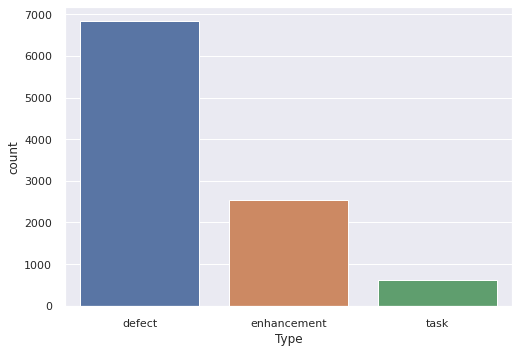

In [55]:
sns.countplot(data = raw_data, x = 'Type')
plt.show()

In [56]:
# Components with count
raw_data['Component'].value_counts()

General                       1691
Tabbed Browser                 850
Preferences                    590
Address Bar                    529
New Tab Page                   511
Toolbars and Customization     436
Theme                          413
Bookmarks & History            403
Session Restore                392
File Handling                  361
Menus                          334
Sync                           324
Security                       294
Messaging System               238
Search                         226
PDF Viewer                     210
Downloads Panel                204
Keyboard Navigation            189
Installer                      178
Shell Integration              169
Site Permissions               168
about:logins                   126
Private Browsing               121
Protections UI                 109
WebPayments UI                 108
Site Identity                   82
Screenshots                     78
Untriaged                       78
Disability Access   

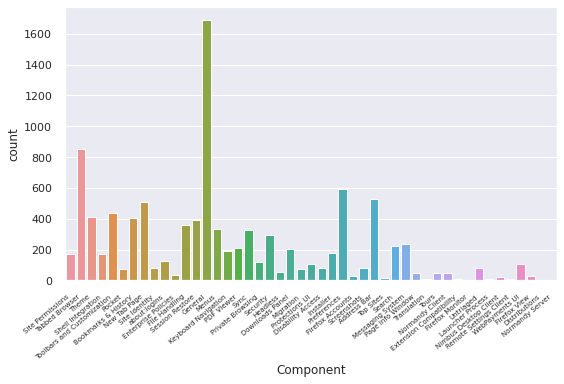

In [57]:
ax = sns.countplot(data = raw_data, x = 'Component')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=7)
plt.tight_layout()
plt.show()

### Natural Language Processing

In [58]:
# Loading Spacy
nlp = spacy.load('en_core_web_lg')

In [59]:
# Apply NLP to all summary column
raw_data.Summary = raw_data.Summary.apply(lambda summary: nlp(summary))

# Display data
raw_data.head()

,Bug ID,Type,Summary,Product,Component,Assignee,Status,Resolution,Updated
0,1653320,defect,"(Global, sharing, indicator, blocks, access, t...",Firefox,Site Permissions,mconley@mozilla.com,UNCONFIRMED,---,2021-08-28 01:05:31
1,1355978,defect,"(show, tab, favicons, immediately)",Firefox,Tabbed Browser,nobody@mozilla.org,UNCONFIRMED,---,2022-07-16 19:20:28
2,1404034,defect,"(Icon, looks, pixelated, on, gnome3)",Firefox,Theme,nobody@mozilla.org,UNCONFIRMED,---,2019-06-12 17:37:21
3,1404295,defect,"(Firefox, developer, edition, -, default, brow...",Firefox,Shell Integration,nobody@mozilla.org,UNCONFIRMED,---,2021-11-24 07:03:37
4,1405504,defect,"(Can, no, longer, scroll, the, tab, bar, using...",Firefox,Tabbed Browser,nobody@mozilla.org,UNCONFIRMED,---,2017-11-01 02:48:05


In [60]:
# Stop words of Spacy Library
stop_words = nlp.Defaults.stop_words

# Copy the data
data = raw_data.copy()

# Removing punctuation (!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~)
# Removing stop words (a , an, the, in, on etc)
# Getting the base words through lematization

data.Summary = raw_data.Summary.apply(lambda doc: [token.lemma_ for token in doc
                                                   if (token.text not in punctuation 
                                                       and token.text.lower() not in stop_words)])
# Display data
data.head()

,Bug ID,Type,Summary,Product,Component,Assignee,Status,Resolution,Updated
0,1653320,defect,"[global, sharing, indicator, block, access, me...",Firefox,Site Permissions,mconley@mozilla.com,UNCONFIRMED,---,2021-08-28 01:05:31
1,1355978,defect,"[tab, favicon, immediately]",Firefox,Tabbed Browser,nobody@mozilla.org,UNCONFIRMED,---,2022-07-16 19:20:28
2,1404034,defect,"[icon, look, pixelated, gnome3]",Firefox,Theme,nobody@mozilla.org,UNCONFIRMED,---,2019-06-12 17:37:21
3,1404295,defect,"[Firefox, developer, edition, default, browser...",Firefox,Shell Integration,nobody@mozilla.org,UNCONFIRMED,---,2021-11-24 07:03:37
4,1405504,defect,"[long, scroll, tab, bar, touch, win, 10, Firef...",Firefox,Tabbed Browser,nobody@mozilla.org,UNCONFIRMED,---,2017-11-01 02:48:05


In [61]:
# Joining the tokens
data.Summary = data.Summary.apply(lambda x: " ".join(x))

# Display data with joined tokens
data.head()

,Bug ID,Type,Summary,Product,Component,Assignee,Status,Resolution,Updated
0,1653320,defect,global sharing indicator block access menu macOS,Firefox,Site Permissions,mconley@mozilla.com,UNCONFIRMED,---,2021-08-28 01:05:31
1,1355978,defect,tab favicon immediately,Firefox,Tabbed Browser,nobody@mozilla.org,UNCONFIRMED,---,2022-07-16 19:20:28
2,1404034,defect,icon look pixelated gnome3,Firefox,Theme,nobody@mozilla.org,UNCONFIRMED,---,2019-06-12 17:37:21
3,1404295,defect,Firefox developer edition default browser issue,Firefox,Shell Integration,nobody@mozilla.org,UNCONFIRMED,---,2021-11-24 07:03:37
4,1405504,defect,long scroll tab bar touch win 10 Firefox beta ...,Firefox,Tabbed Browser,nobody@mozilla.org,UNCONFIRMED,---,2017-11-01 02:48:05


In [62]:
# Save pre-processed data
data.to_csv("processed_data.csv")

## Classification on the basis of Type 

### Spliting the data into train and test set:

In [63]:
# Input features
X = data['Summary']

# target
y = data['Type']

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42)

In [64]:
def process(classifier):
  # pipeline with Linear SVC
  bug_clf = Pipeline([('tfidf', TfidfVectorizer()),
                      ('clf',  classifier)])
  bug_clf.fit(X_train, y_train)
  predictions = bug_clf.predict(X_test)

  # Report the confusion matrix
  metrics.plot_confusion_matrix(bug_clf, X_test, y_test,
                                  display_labels=data['Type'].unique().tolist(),
                                  cmap=plt.cm.Blues,
                                  normalize=None)

  plt.show()

  # Print a classification report
  visualizer = classification_report(
      bug_clf, X_train, y_train, X_test, y_test, cmap='YlOrRd', classes=data['Type'].unique().tolist(), support=True
  )


  # print accuracy
  print('Accuracy: ', metrics.accuracy_score(y_test, predictions))

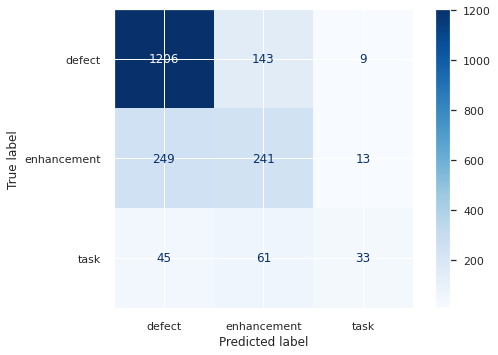

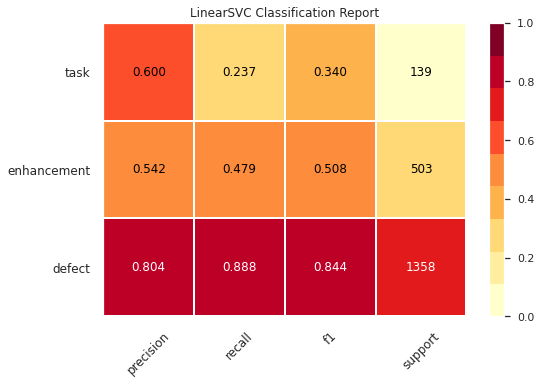

Accuracy:  0.74


In [65]:
process(LinearSVC())

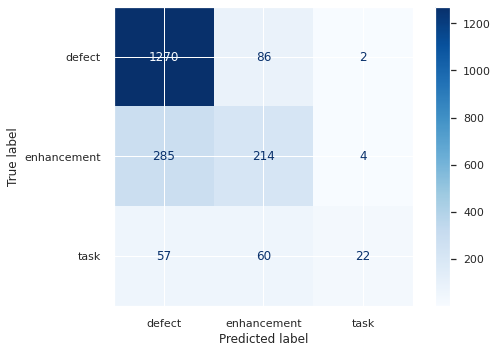

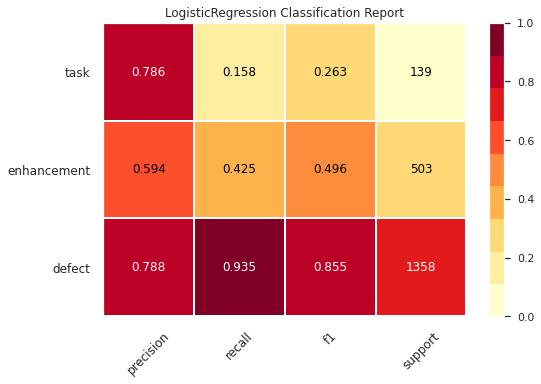

Accuracy:  0.753


In [66]:
process(LogisticRegression(solver='lbfgs', max_iter=1000))

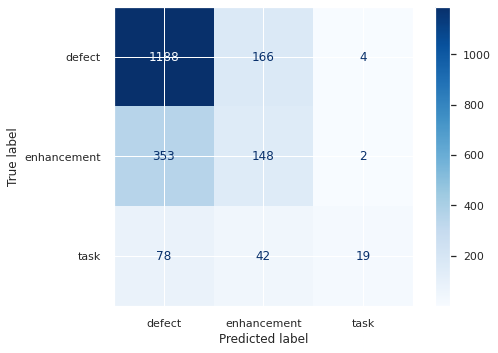

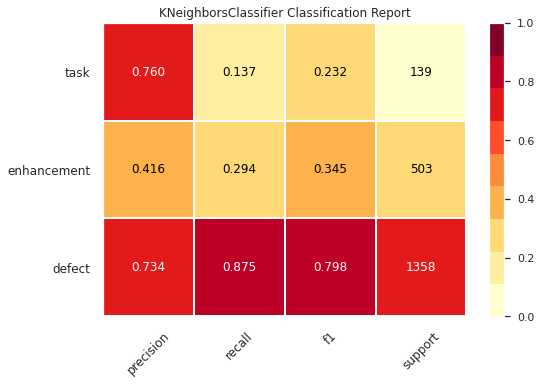

Accuracy:  0.6775


In [67]:
process(KNeighborsClassifier())

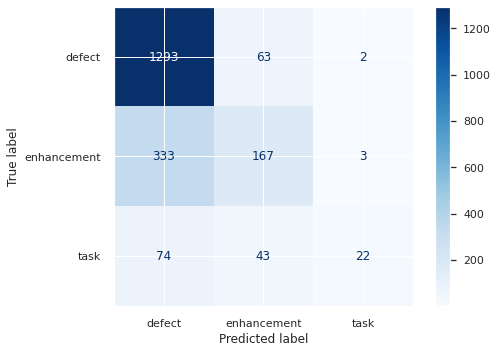

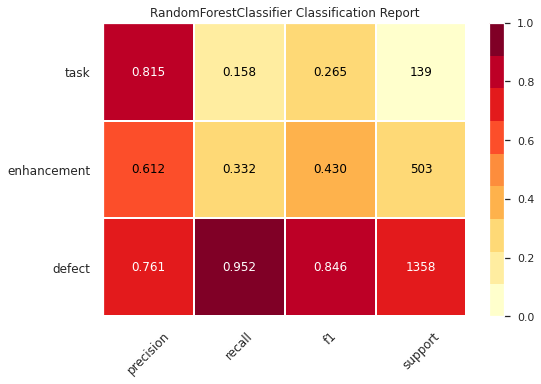

Accuracy:  0.741


In [68]:
process(RandomForestClassifier(max_depth=120, random_state=42))

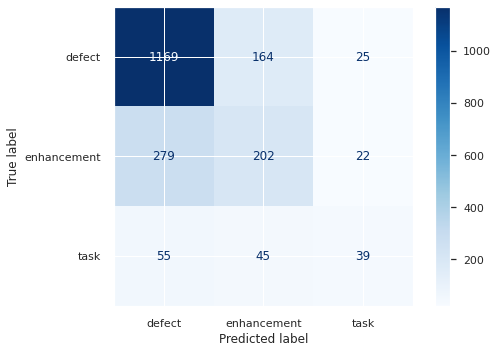

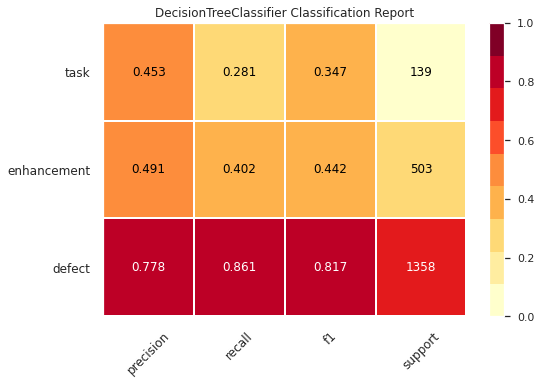

Accuracy:  0.705


In [69]:
process(DecisionTreeClassifier(max_depth=100, random_state=42))

## Classfication on the basis of components

In [70]:
# Input features
X = data['Summary']

# target
y = data['Component']

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42)

In [71]:
def process_component(classifier):
  # pipeline with Linear SVC
  bug_clf = Pipeline([('tfidf', TfidfVectorizer()),
                      ('clf',  LinearSVC())])
  bug_clf.fit(X_train, y_train)
  predictions = bug_clf.predict(X_test)

  # Report the confusion matrix
  print('Confusion Matrix: \n', metrics.confusion_matrix(y_test,predictions))
  print()

  # Print a classification report
  print(metrics.classification_report(y_test,predictions))

  # print accuracy
  print('Accuracy: ', metrics.accuracy_score(y_test, predictions))

In [72]:
process_component(LinearSVC())

Confusion Matrix: 
 [[68  1  1 ...  0  1  0]
 [ 1 61  0 ...  0  0  0]
 [ 0  0  2 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0 14  1]
 [ 0  0  0 ...  0  1 16]]

                            precision    recall  f1-score   support

               Address Bar       0.63      0.60      0.61       114
       Bookmarks & History       0.72      0.73      0.73        83
         Disability Access       0.33      0.15      0.21        13
           Downloads Panel       0.69      0.61      0.65        54
       Enterprise Policies       0.86      0.86      0.86         7
   Extension Compatibility       0.00      0.00      0.00         1
             File Handling       0.52      0.46      0.49        83
          Firefox Accounts       0.00      0.00      0.00         6
              Firefox View       0.75      0.30      0.43        10
                   General       0.45      0.59      0.51       315
                  Headless       0.90      0.75      0.82        12
      

In [73]:
process_component(LogisticRegression(solver='lbfgs', max_iter=1000))

Confusion Matrix: 
 [[68  1  1 ...  0  1  0]
 [ 1 61  0 ...  0  0  0]
 [ 0  0  2 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0 14  1]
 [ 0  0  0 ...  0  1 16]]

                            precision    recall  f1-score   support

               Address Bar       0.63      0.60      0.61       114
       Bookmarks & History       0.72      0.73      0.73        83
         Disability Access       0.33      0.15      0.21        13
           Downloads Panel       0.69      0.61      0.65        54
       Enterprise Policies       0.86      0.86      0.86         7
   Extension Compatibility       0.00      0.00      0.00         1
             File Handling       0.52      0.46      0.49        83
          Firefox Accounts       0.00      0.00      0.00         6
              Firefox View       0.75      0.30      0.43        10
                   General       0.45      0.59      0.51       315
                  Headless       0.90      0.75      0.82        12
      

In [74]:
process_component(KNeighborsClassifier())

Confusion Matrix: 
 [[68  1  1 ...  0  1  0]
 [ 1 61  0 ...  0  0  0]
 [ 0  0  2 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0 14  1]
 [ 0  0  0 ...  0  1 16]]

                            precision    recall  f1-score   support

               Address Bar       0.63      0.60      0.61       114
       Bookmarks & History       0.72      0.73      0.73        83
         Disability Access       0.33      0.15      0.21        13
           Downloads Panel       0.69      0.61      0.65        54
       Enterprise Policies       0.86      0.86      0.86         7
   Extension Compatibility       0.00      0.00      0.00         1
             File Handling       0.52      0.46      0.49        83
          Firefox Accounts       0.00      0.00      0.00         6
              Firefox View       0.75      0.30      0.43        10
                   General       0.45      0.59      0.51       315
                  Headless       0.90      0.75      0.82        12
      

In [75]:
process_component(RandomForestClassifier(max_depth=120, random_state=42))

Confusion Matrix: 
 [[68  1  1 ...  0  1  0]
 [ 1 61  0 ...  0  0  0]
 [ 0  0  2 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0 14  1]
 [ 0  0  0 ...  0  1 16]]

                            precision    recall  f1-score   support

               Address Bar       0.63      0.60      0.61       114
       Bookmarks & History       0.72      0.73      0.73        83
         Disability Access       0.33      0.15      0.21        13
           Downloads Panel       0.69      0.61      0.65        54
       Enterprise Policies       0.86      0.86      0.86         7
   Extension Compatibility       0.00      0.00      0.00         1
             File Handling       0.52      0.46      0.49        83
          Firefox Accounts       0.00      0.00      0.00         6
              Firefox View       0.75      0.30      0.43        10
                   General       0.45      0.59      0.51       315
                  Headless       0.90      0.75      0.82        12
      

In [76]:
process_component(DecisionTreeClassifier(max_depth=100, random_state=42))

Confusion Matrix: 
 [[68  1  1 ...  0  1  0]
 [ 1 61  0 ...  0  0  0]
 [ 0  0  2 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0 14  1]
 [ 0  0  0 ...  0  1 16]]

                            precision    recall  f1-score   support

               Address Bar       0.63      0.60      0.61       114
       Bookmarks & History       0.72      0.73      0.73        83
         Disability Access       0.33      0.15      0.21        13
           Downloads Panel       0.69      0.61      0.65        54
       Enterprise Policies       0.86      0.86      0.86         7
   Extension Compatibility       0.00      0.00      0.00         1
             File Handling       0.52      0.46      0.49        83
          Firefox Accounts       0.00      0.00      0.00         6
              Firefox View       0.75      0.30      0.43        10
                   General       0.45      0.59      0.51       315
                  Headless       0.90      0.75      0.82        12
      

## BERT 

In [77]:
!pip install simpletransformer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement simpletransformer (from versions: none)
ERROR: No matching distribution found for simpletransformer


In [78]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import pandas as pd
import numpy as np
import spacy
import requests
import datetime as dt
import random
import time
import torch
from scipy.special import softmax
import logging
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pickle
import json
import warnings
warnings.filterwarnings('ignore')

### Data pre-processing

In [79]:
# read excel file
data = pd.read_csv('processed_data.csv')
data.head()
data = shuffle(data)

# Get all types as list
types = data['Type'].unique().tolist()  
# map labels with index of the list
data['Type label']  = data.Type.map(lambda v: types.index(v))
#Intents training data ["text", "labels"]
train_data_types = data[['Summary', 'Type label']].rename(columns={'Summary': "text",
                                                      'Type label':"labels"})

# Get all components as list
components = data['Component'].unique().tolist()
# map labels with index of the list
data['Component label']  = data.Component.map(lambda v: components.index(v))
#Intents training data ["text", "labels"]
train_data_components = data[['Summary', 'Component label']].rename(columns={'Summary': "text",
                                                      'Component label':"labels"})



In [80]:
X = train_data_types['text']
y = train_data_types['labels']

#X = train_data_components['text']
#y = train_data_components['labels']

In [81]:
# split the data 80/20 for train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42)

In [82]:
# training dataframe
train_df = pd.DataFrame()
train_df['text'] = X_train
train_df['labels'] = y_train

# testing/evaluation dataframe
eval_df = pd.DataFrame()
eval_df['text'] = X_test
eval_df['labels'] = y_test

In [83]:
# Save types & components
with open('types.json', 'w') as file:
    json.dump(types, file)

with open('components.json', 'w') as file:
    json.dump(components, file)

### Classification on the basis of Type

#### Training the model

In [84]:
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

#defining paramenters
model_type = "bert" 
model_name = "bert-base-uncased"
output_directory = '/models/model_type/'
cuda_available = torch.cuda.is_available()
hide_progress = False

model_args = {
    "reprocess_input_data": True,
    "output_dir": output_directory,
    "overwrite_output_dir": True,
    "train_batch_size": 32,
    "num_train_epochs": 50,
    "save_eval_checkpoints": False,
    "save_steps": -1,
    "save_model_every_epoch": False,
    "use_multiprocessing": True,
    "manual_seed": 4,
    "no_cache": True,
    "evaluate_during_training": True,
    "evaluate_during_training_steps": 100,
    "silent": hide_progress,
    "use_early_stopping": False,
    "early_stopping_delta": 0.01,
    "early_stopping_metric": "acc",
    "early_stopping_metric_minimize": False,
    "early_stopping_patience": 4,    
    "learning_rate": 1e-4
}

# Create a TransformerModel
model = ClassificationModel(
      model_type,
      model_name,
      num_labels=len(types),
      args=model_args,
      use_cuda=cuda_available,

) 

# Train the model
hist = model.train_model(train_df, eval_df=eval_df, acc=accuracy_score)

# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(eval_df, acc=accuracy_score)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

  0%|          | 0/8000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Running Epoch 0 of 50:   0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Running Epoch 1 of 50:   0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Running Epoch 2 of 50:   0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Running Epoch 3 of 50:   0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Running Epoch 4 of 50:   0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Running Epoch 5 of 50:   0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Running Epoch 6 of 50:   0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Running Epoch 7 of 50:   0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Running Epoch 8 of 50:   0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Running Epoch 9 of 50:   0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Running Epoch 10 of 50:   0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Running Epoch 11 of 50:   0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Running Epoch 12 of 50:   0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Running Epoch 13 of 50:   0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Running Epoch 14 of 50:   0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Running Epoch 15 of 50:   0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Running Epoch 16 of 50:   0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Running Epoch 17 of 50:   0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Running Epoch 18 of 50:   0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Running Epoch 19 of 50:   0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Running Epoch 20 of 50:   0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Running Epoch 21 of 50:   0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Running Epoch 22 of 50:   0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Running Epoch 23 of 50:   0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Running Epoch 24 of 50:   0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Running Epoch 25 of 50:   0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Running Epoch 26 of 50:   0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Running Epoch 27 of 50:   0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Running Epoch 28 of 50:   0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Running Epoch 29 of 50:   0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Running Epoch 30 of 50:   0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Running Epoch 31 of 50:   0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Running Epoch 32 of 50:   0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Running Epoch 33 of 50:   0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Running Epoch 34 of 50:   0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Running Epoch 35 of 50:   0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Running Epoch 36 of 50:   0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Running Epoch 37 of 50:   0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Running Epoch 38 of 50:   0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Running Epoch 39 of 50:   0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Running Epoch 40 of 50:   0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Running Epoch 41 of 50:   0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Running Epoch 42 of 50:   0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Running Epoch 43 of 50:   0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Running Epoch 44 of 50:   0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Running Epoch 45 of 50:   0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Running Epoch 46 of 50:   0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Running Epoch 47 of 50:   0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Running Epoch 48 of 50:   0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Running Epoch 49 of 50:   0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/250 [00:00<?, ?it/s]

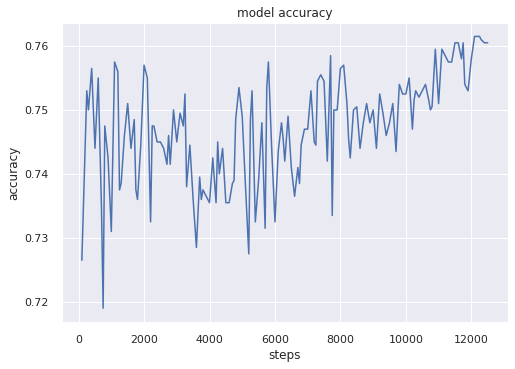

In [85]:
plt.plot(hist[1]['global_step'], hist[1]['acc'])
plt.xlabel('steps')
plt.ylabel('accuracy')
plt.title('model accuracy')
plt.show()

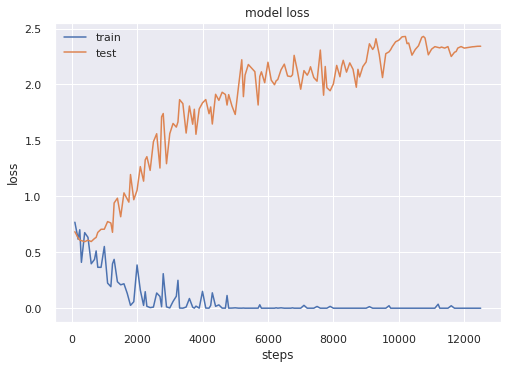

In [86]:
plt.plot(hist[1]['global_step'], hist[1]['train_loss'])
plt.plot(hist[1]['global_step'], hist[1]['eval_loss'])
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Loading saved model

In [87]:
# defining accessories
cuda_available = torch.cuda.is_available()
model_directory = "/content/outputs/best_model/"
model_args = "/content/outputs/best_model/model_args.json"
 
model_type =  "bert"

model_type = ClassificationModel(
    model_type,
    model_name = model_directory,
    args=model_args,
    use_cuda=cuda_available,
)

with open('/content/types.json') as file:
   types = json.load(file)

### Predictions

In [88]:
def predict_type(sentence, model_type):
  model_type.args.silent= True
  model_type.args.use_multiprocessing_for_evaluation = False 
  predictions, raw_outputs = model_type.predict([sentence])
  probabilities = softmax(raw_outputs, axis=1)
  results = {'label': types[predictions[0]], 
           'score': probabilities[0][predictions[0]] }
  return predictions[0]  # results

In [89]:
# For the purpose of evaluation ... 
predicted_labels = []
for inp in X_test:
  predicted_labels.append(predict_type(inp, model_type))

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predicted_labels)

In [ ]:
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, predicted_labels, normalize= 'all')
labels = types # types
fig, ax = plt.subplots()
h = ax.matshow(cm)
fig.colorbar(h)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
ax.set_xlabel('Predicted')
ax.set_ylabel('Ground truth')

In [ ]:
from sklearn import metrics

print('Accuracy: ', metrics.accuracy_score(y_test, predicted_labels))

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predicted_labels ))

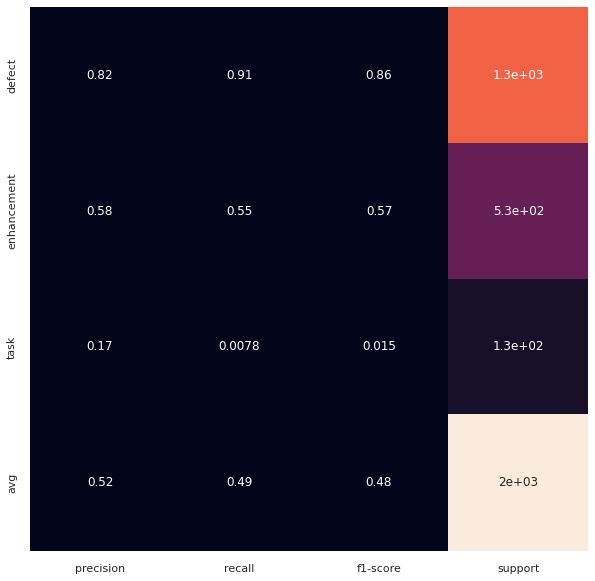

In [90]:
import numpy as np
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt

y, y_p = y_test, predicted_labels

def plot_classification_report(y_tru, y_prd, figsize=(10, 10), ax=None):

    plt.figure(figsize=figsize)

    xticks = ['precision', 'recall', 'f1-score', 'support']
    yticks = types  #list(np.unique(y_tru))
    yticks += ['avg']

    rep = np.array(precision_recall_fscore_support(y_tru, y_prd)).T
    avg = np.mean(rep, axis=0)
    avg[-1] = np.sum(rep[:, -1])
    rep = np.insert(rep, rep.shape[0], avg, axis=0)

    sns.heatmap(rep,
                annot=True, 
                cbar=False, 
                xticklabels=xticks, 
                yticklabels=yticks,
                ax=ax)

plot_classification_report(y, y_p)